In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower')
plt.rc('figure', figsize=(10, 6))

In [3]:
import pandas as pd
import numpy as np
import astropy.units as u

In [4]:
def file2df(file):
    with open(file, 'r') as ff:
        line = ff.readline()
        cols = line.strip('#').split()
        print(cols)
    return pd.read_csv(file, comment='#', delim_whitespace=True, names=cols)

In [5]:
obs = file2df('../LSSTsimWDobs60.dat')
truth = file2df('../LSSTsimWDtruth60.dat')

['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs', 'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObsmuDecObs', 'muErr']
['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'y', 'Mr', 'logg', 'vR', 'vPhi', 'vZ', 'T', 'P']


In [6]:
obs.head()

,ra,dec,uObs,uErr,gObs,gErr,rObs,rErr,iObs,iErr,zObs,zErr,yObs,yErr,piObs,piErr,muRAObsmuDecObs,muErr
183.487,-1.36738,22.462,0.009,22.274,0.005,22.572,0.005,22.842,0.007,23.127,0.013,23.408,0.048,1.02,0.91,-1.60,-6.76,0.32
183.261,-1.25781,25.574,0.106,25.173,0.024,25.251,0.022,25.338,0.046,25.570,0.112,25.723,0.400,1.17,8.95,-3.19,-9.73,3.09
183.038,-1.32316,24.688,0.050,24.341,0.012,24.302,0.010,24.356,0.019,24.442,0.042,24.845,0.140,2.90,3.84,1.84,0.17,1.32
183.127,-1.13602,23.267,0.015,22.912,0.006,22.835,0.006,22.867,0.007,22.966,0.012,23.066,0.035,0.24,1.11,-12.58,3.17,0.38
183.339,-1.39733,23.504,0.018,23.093,0.006,22.963,0.006,22.957,0.007,23.034,0.012,23.088,0.036,-0.23,1.22,-8.69,-10.08,0.42


In [7]:
obs.set_index(truth.index)

,ra,dec,uObs,uErr,gObs,gErr,rObs,rErr,iObs,iErr,zObs,zErr,yObs,yErr,piObs,piErr,muRAObsmuDecObs,muErr
0,-1.36738,22.462,0.009,22.274,0.005,22.572,0.005,22.842,0.007,23.127,0.013,23.408,0.048,1.02,0.91,-1.60,-6.76,0.32
1,-1.25781,25.574,0.106,25.173,0.024,25.251,0.022,25.338,0.046,25.570,0.112,25.723,0.400,1.17,8.95,-3.19,-9.73,3.09
2,-1.32316,24.688,0.050,24.341,0.012,24.302,0.010,24.356,0.019,24.442,0.042,24.845,0.140,2.90,3.84,1.84,0.17,1.32
3,-1.13602,23.267,0.015,22.912,0.006,22.835,0.006,22.867,0.007,22.966,0.012,23.066,0.035,0.24,1.11,-12.58,3.17,0.38
4,-1.39733,23.504,0.018,23.093,0.006,22.963,0.006,22.957,0.007,23.034,0.012,23.088,0.036,-0.23,1.22,-8.69,-10.08,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906212,52.60660,30.592,2.015,27.999,0.309,27.917,0.186,27.628,0.312,26.491,0.624,31.346,1.825,56.82,77.41,-4.67,-22.36,26.69
906213,52.72680,28.033,1.270,27.386,0.184,27.104,0.107,26.839,0.175,25.812,0.345,26.798,0.993,-2.43,44.35,25.10,26.89,15.29
906214,52.52160,28.775,1.821,27.489,0.228,26.867,0.118,26.902,0.183,26.578,0.346,27.311,0.956,-26.95,49.08,11.62,4.79,16.93
906215,52.46750,25.601,2.447,28.214,0.264,27.025,0.124,26.724,0.181,26.502,0.328,25.696,0.869,-62.50,51.37,-0.92,-3.60,17.71


In [14]:
obs.reset_index(inplace=True)
obs.columns = ['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs', 'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs',' muDecObs', 'muErr']

In [15]:
obs.head()

,ra,dec,uObs,uErr,gObs,gErr,rObs,rErr,iObs,iErr,zObs,zErr,yObs,yErr,piObs,piErr,muRAObs,muDecObs,muErr
0,183.487,-1.36738,22.462,0.009,22.274,0.005,22.572,0.005,22.842,0.007,23.127,0.013,23.408,0.048,1.02,0.91,-1.60,-6.76,0.32
1,183.261,-1.25781,25.574,0.106,25.173,0.024,25.251,0.022,25.338,0.046,25.570,0.112,25.723,0.400,1.17,8.95,-3.19,-9.73,3.09
2,183.038,-1.32316,24.688,0.050,24.341,0.012,24.302,0.010,24.356,0.019,24.442,0.042,24.845,0.140,2.90,3.84,1.84,0.17,1.32
3,183.127,-1.13602,23.267,0.015,22.912,0.006,22.835,0.006,22.867,0.007,22.966,0.012,23.066,0.035,0.24,1.11,-12.58,3.17,0.38
4,183.339,-1.39733,23.504,0.018,23.093,0.006,22.963,0.006,22.957,0.007,23.034,0.012,23.088,0.036,-0.23,1.22,-8.69,-10.08,0.42


In [13]:
truth.head()

,ra,dec,u,g,r,i,z,y,Mr,logg,vR,vPhi,vZ,T,P
0,183.487,-1.36738,22.454,22.269,22.566,22.846,23.133,23.420,11.338,8.0,-50.89,-134.57,40.51,1,1
1,183.261,-1.25781,25.549,25.183,25.235,25.364,25.546,25.729,12.346,8.0,-51.56,-53.51,-3.59,1,1
2,183.038,-1.32316,24.718,24.354,24.301,24.356,24.471,24.587,12.867,8.0,-47.11,-170.19,94.17,1,1
3,183.127,-1.13602,23.288,22.913,22.834,22.871,22.972,23.073,12.989,8.0,29.71,-196.22,33.81,1,1
4,183.339,-1.39733,23.517,23.099,22.959,22.960,23.030,23.100,13.249,8.0,-4.74,-187.17,-37.27,1,1


## Problem A

Define a \gold parallax sample" by requiring a signal-to-noise ratio of
at least 10 for the trigonometric parallax measurement (i.e., piObs/piErr >
10). Compute the distance and distance modulus from the parallax measurement (D/kpc=1 milliarcsec/piObs) and compare it to the distance modulus
determined from r and Mr listed in the \truth" file. Plot the distribution
of the distance modulus difference and compute its median and root-mean-
square scatter (hint: beware of outliers and clip at 3sig!). Are they \inter-
estingly" small? Is the distribution deviating from a gaussian? Would you
expect it to? Why? How many white dwarfs would you expect in a \gold
parallax sample" from the full LSST survey area of 20,000 deg2 (hint: simply
scale by the area because the distance cutoff is smaller than the thin disk
scaleheight)? Plot the (g-r) vs. (u-g) color-color diagram (using observed
photometry) for this sample. Does it look crisper than the SDSS distribution
1https://ls.st/lop
2
shown in the bottom left corner of fig. 23 in Ivezic et al. (2007, AJ, 134, 973)?

In [35]:
obs['SNR'] = obs['piObs'] / obs['piErr']
obs['gold_pi'] = obs['SNR'] > 10
obs['D(kpc)'] = 1 / obs['piObs']
obs['Mr'] = obs['rObs'] - 5 * np.log10(obs['D(kpc)'] * 1000 / 10)

C:\Users\ykwan\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


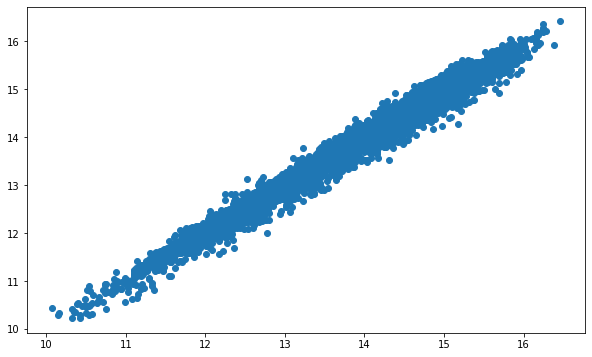

In [36]:
plt.scatter(obs.loc[obs['gold_pi'], 'Mr'], truth.loc[obs['gold_pi'], 'Mr'])

(array([3.000e+00, 7.000e+00, 1.400e+01, 8.000e+01, 1.580e+02, 4.900e+02,
        8.620e+02, 1.429e+03, 1.540e+03, 1.140e+03, 6.730e+02, 3.700e+02,
        1.910e+02, 9.900e+01, 5.500e+01, 2.600e+01, 1.300e+01, 2.000e+00,
        3.000e+00, 1.000e+00]),
 array([-6.01759516e-01, -5.26572224e-01, -4.51384932e-01, -3.76197640e-01,
        -3.01010348e-01, -2.25823056e-01, -1.50635764e-01, -7.54484717e-02,
        -2.61179651e-04,  7.49261124e-02,  1.50113405e-01,  2.25300697e-01,
         3.00487989e-01,  3.75675281e-01,  4.50862573e-01,  5.26049865e-01,
         6.01237157e-01,  6.76424449e-01,  7.51611741e-01,  8.26799033e-01,
         9.01986326e-01]),
 <a list of 20 Patch objects>)

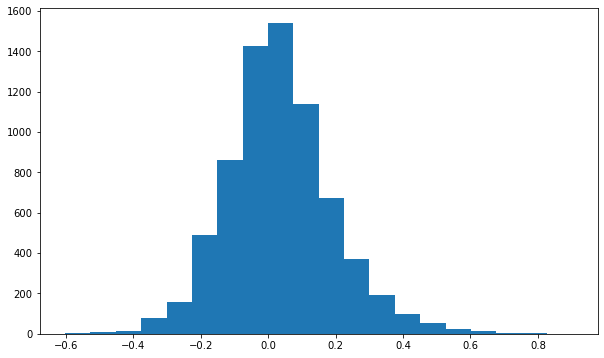

In [39]:
obs.loc[obs['gold_pi'], 'delMr'] = obs.loc[obs['gold_pi'], 'Mr'] - truth.loc[obs['gold_pi'], 'Mr']
plt.hist(obs['delMr'], bins=20 )

In [60]:
factor = 20000 * u.deg ** 2 / (2* np.pi * (1 - np.cos(np.pi/6)) * u.sr).to(u.deg ** 2)

In [62]:
sum(obs['gold_pi']) * factor

<Quantity 51790.81407997>

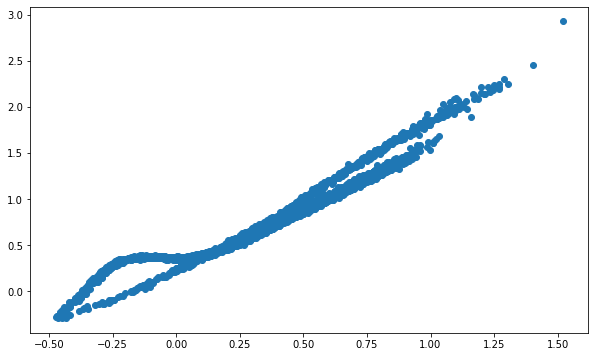

In [64]:
plt.scatter(obs.loc[obs['gold_pi'], 'gObs'] - obs.loc[obs['gold_pi'], 'rObs'], obs.loc[obs['gold_pi'], 'uObs'] - obs.loc[obs['gold_pi'], 'gObs'])